# Importing the Important Libraries

In [1]:
import os
import pandas as pd
import numpy as np

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC

In [2]:
spam = pd.read_csv("SMSSpamCollection.csv", header=0, names=['spamorham', 'text'])
print(spam.shape)
spam.head(10)

(5571, 2)


,spamorham,text
0,ham,Ok lar... Joking wif u oni...
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...
2,ham,U dun say so early hor... U c already then say...
3,ham,"Nah I don't think he goes to usf, he lives aro..."
4,spam,FreeMsg Hey there darling it's been 3 week's n...
5,ham,Even my brother is not like to speak with me. ...
6,ham,As per your request 'Melle Melle (Oru Minnamin...
7,spam,WINNER!! As a valued network customer you have...
8,spam,Had your mobile 11 months or more? U R entitle...
9,ham,I'm gonna be home soon and i don't want to tal...


# Data Preprocessing

In [3]:
#creating a target col, with 0 for ham, 1 for spam
df = spam.drop(columns="spamorham")
df["spam"] = spam["spamorham"].apply(lambda x:1 if 'spam' in str(x)
                                  else 0)
df.columns=['text','target']
df.head(10)

,text,target
0,Ok lar... Joking wif u oni...,0
1,Free entry in 2 a wkly comp to win FA Cup fina...,1
2,U dun say so early hor... U c already then say...,0
3,"Nah I don't think he goes to usf, he lives aro...",0
4,FreeMsg Hey there darling it's been 3 week's n...,1
5,Even my brother is not like to speak with me. ...,0
6,As per your request 'Melle Melle (Oru Minnamin...,0
7,WINNER!! As a valued network customer you have...,1
8,Had your mobile 11 months or more? U R entitle...,1
9,I'm gonna be home soon and i don't want to tal...,0


# Exploratory Data Analysis
13.409% are spam

In [4]:
df['target'].mean()*100

13.408723747980615

In [5]:
#creating two seperate dfs: 1 for spam and 1 for non spam messages only
df_s = df.loc[ df['target']==1]
df_ns = df.loc[ df['target']==0]

df_s['len'] = [len(x) for x in df_s["text"]]
spamavg = df_s.len.mean()
print('df_s.head(5)')
print(df_s.head(5))

print('\n\ndf_ns.head(5)')
df_ns['len'] = [len(x) for x in df_ns["text"]]
nonspamavg = df_ns.len.mean()
print(df_ns.head(5))

df_s.head(5)
                                                 text  target  len
1   Free entry in 2 a wkly comp to win FA Cup fina...       1  155
4   FreeMsg Hey there darling it's been 3 week's n...       1  148
7   WINNER!! As a valued network customer you have...       1  158
8   Had your mobile 11 months or more? U R entitle...       1  154
10  SIX chances to win CASH! From 100 to 20,000 po...       1  136


df_ns.head(5)
                                                text  target  len
0                      Ok lar... Joking wif u oni...       0   29
2  U dun say so early hor... U c already then say...       0   49
3  Nah I don't think he goes to usf, he lives aro...       0   61
5  Even my brother is not like to speak with me. ...       0   77
6  As per your request 'Melle Melle (Oru Minnamin...       0  160


<ipython-input-5-c5423c3ffa94>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_s['len'] = [len(x) for x in df_s["text"]]
<ipython-input-5-c5423c3ffa94>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ns['len'] = [len(x) for x in df_ns["text"]]


In [6]:
spamavg

139.11914323962517

In [7]:
nonspamavg

71.55078772802653

In [8]:
df['length'] = df['text'].apply(lambda x: len(''.join([a for a in x if a.isdigit()])))

print(np.mean(df['length'][df['target'] == 0]), np.mean(df['length'][df['target'] == 1]))

print(df.head(10))

0.30534825870646765 15.812583668005354
                                                text  target  length
0                      Ok lar... Joking wif u oni...       0       0
1  Free entry in 2 a wkly comp to win FA Cup fina...       1      25
2  U dun say so early hor... U c already then say...       0       0
3  Nah I don't think he goes to usf, he lives aro...       0       0
4  FreeMsg Hey there darling it's been 3 week's n...       1       4
5  Even my brother is not like to speak with me. ...       0       0
6  As per your request 'Melle Melle (Oru Minnamin...       0       1
7  WINNER!! As a valued network customer you have...       1      19
8  Had your mobile 11 months or more? U R entitle...       1      13
9  I'm gonna be home soon and i don't want to tal...       0       0


# Data Modelling
### MNNB Model Fitting 1

In [43]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(df['text'],
                                                    df['target'],
                                                    random_state=0)

In [44]:
#fitting and transforming X_train using a Count Vectorizer with default parameters
vect = CountVectorizer().fit(X_train)
X_train_vectorized = vect.transform(X_train)

In [45]:
vect

CountVectorizer()

In [46]:
X_train_vectorized

<4178x7416 sparse matrix of type '<class 'numpy.int64'>'
	with 55415 stored elements in Compressed Sparse Row format>

In [47]:
#fitting a multinomial Naive Bayes Classifier Model with smoothing alpha=0.1
model = sklearn.naive_bayes.MultinomialNB(alpha=0.1)
model_fit = model.fit(X_train_vectorized, y_train)

In [48]:
#making predictions & looking at AUC score
predictions = model.predict(vect.transform(X_test))
aucscore = roc_auc_score(y_test, predictions) #good!
aucscore

0.9615532083312719

In [49]:
#confusion matrix
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print(pd.DataFrame(confusion_matrix(y_test, predictions),
             columns=['Predicted Spam', "Predicted Ham"], index=['Actual Spam', 'Actual Ham']))

print(f'\nTrue Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

print(f'\nTrue Positive Rate: { (tp / (tp + fn))}')
print(f'Specificity: { (tn / (tn + fp))}')
print(f'False Positive Rate: { (fp / (fp + tn))}')

             Predicted Spam  Predicted Ham
Actual Spam            1185              4
Actual Ham               15            189

True Positives: 189
False Positives: 4
True Negatives: 1185
False Negatives: 15

True Positive Rate: 0.9264705882352942
Specificity: 0.9966358284272497
False Positive Rate: 0.00336417157275021


### SVC Model

In [37]:
#defining an additional function
def add_feature(X, feature_to_add):
    """
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    """
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [38]:
#fit and transfor x_train and X_test
vectorizer = TfidfVectorizer(min_df=5)

X_train_transformed = vectorizer.fit_transform(X_train)
X_train_transformed_with_length = add_feature(X_train_transformed, X_train.str.len())

X_test_transformed = vectorizer.transform(X_test)
X_test_transformed_with_length = add_feature(X_test_transformed, X_test.str.len())



In [39]:
# SVM creation
clf = SVC(C=10000)

clf.fit(X_train_transformed_with_length, y_train)

SVC(C=10000)

In [40]:
y_predicted = clf.predict(X_test_transformed_with_length)

In [41]:
roc_auc_score(y_test, y_predicted)

0.97422863173865

In [42]:
#confusion matrix
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_predicted).ravel()
print(pd.DataFrame(confusion_matrix(y_test, y_predicted),
             columns=['Predicted Spam', "Predicted Ham"], index=['Actual Spam', 'Actual Ham']))
print(f'\nTrue Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')


print(f'True Positive Rate: { (tp / (tp + fn))}')
print(f'Specificity: { (tn / (tn + fp))}')
print(f'False Positive Rate: { (fp / (fp + tn))}')

             Predicted Spam  Predicted Ham
Actual Spam            1186              3
Actual Ham               10            194

True Positives: 194
False Positives: 3
True Negatives: 1186
False Negatives: 10
True Positive Rate: 0.9509803921568627
Specificity: 0.9974768713204374
False Positive Rate: 0.002523128679562658


# Model Comparison
adapted from https://medium.com/python-pandemonium/data-visualization-in-python-bar-graph-in-matplotlib-f1738602e9c4
and https://stackoverflow.com/questions/45946970/displaying-of-values-on-barchart

<ipython-input-50-ac2e2fe5545e>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g=sb.barplot(x=index, y=auclist, palette=clrs) # color=clrs)


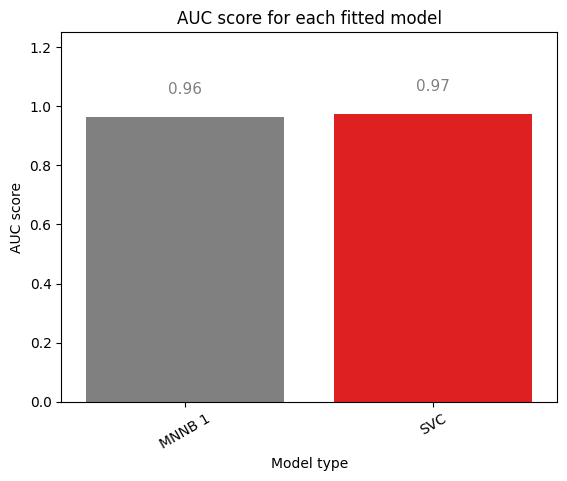

In [50]:
import seaborn as sb
import matplotlib.pyplot as plt

label = ['MNNB 1', 'SVC']
auclist = [0.9615532083312719, 0.97422863173865]

#generates an array of length label and use it on the X-axis
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(label))
    clrs = ['grey' if (x < max(auclist)) else 'red' for x in auclist ]
    g=sb.barplot(x=index, y=auclist, palette=clrs) # color=clrs)
    plt.xlabel('Model type', fontsize=10)
    plt.ylabel('AUC score', fontsize=10)
    plt.xticks(index, label, fontsize=10, rotation=30)
    plt.title('AUC score for each fitted model')
    ax=g
    for p in ax.patches:
             ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                 textcoords='offset points')
    g.set_ylim(0,1.25) #To make space for the annotations

plot_bar_x()